In [1]:
import altair as alt

from traffic.core import Traffic
from traffic.core.projection import EuroPP
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.mixture import GaussianMixture
from sklearn.covariance import LedoitWolf
from sklearn.preprocessing import MinMaxScaler

from deep_traffic_generation.core.builders import CollectionBuilder, IdentifierBuilder, TimestampBuilder
from deep_traffic_generation.core.utils import traffic_from_data, plot_clusters

import torch
from tqdm import tqdm

import warnings
warnings.filterwarnings("ignore")

In [2]:
features = ["latitude", "longitude", "altitude", "timedelta"]

In [3]:
t = Traffic.from_file("../deep_traffic_generation/data/traffic_15.pkl").drop(columns=["cluster"])
t

,count
flight_id,
ABP721_057,200
SWR134J_9747,200
SWR134J_9730,200
SWR134J_9731,200
SWR134J_9732,200
SWR134J_9733,200
SWR134J_9734,200
SWR134J_9736,200
SWR134J_9737,200


### GMM

In [4]:
# extract features
X = np.stack(list(f.data[features].values.ravel() for f in t))
X.shape

(3968, 800)

In [5]:
transform = MinMaxScaler(feature_range=(-1, 1)).fit(X)
X = transform.transform(X)
cov = LedoitWolf().fit(X)

In [6]:
gmm = GaussianMixture(n_components=1, means_init=cov.location_[np.newaxis, ...], precisions_init=cov.get_precision()[np.newaxis, ...]).fit(X)

In [7]:
samples, labels = gmm.sample(1000)
samples.shape

(1000, 800)

In [8]:
samples = transform.inverse_transform(samples)
samples.shape

(1000, 800)

In [9]:
builder = CollectionBuilder([
    IdentifierBuilder(1000, 200),
    TimestampBuilder()
])

t_gen = traffic_from_data(samples, features, builder=builder)
if "track" not in t_gen.data.columns:
    t_gen = (
        t_gen
        .cumulative_distance()
        .rename(columns=dict(compute_gs="groundspeed", compute_track="track"))
        .eval(desc="")
    )

t_gen

  0%|          | 0/1000 [00:00<?, ?it/s]

,count
flight_id,
TRAJ_0,200
TRAJ_702,200
TRAJ_691,200
TRAJ_692,200
TRAJ_693,200
TRAJ_694,200
TRAJ_695,200
TRAJ_696,200
TRAJ_697,200


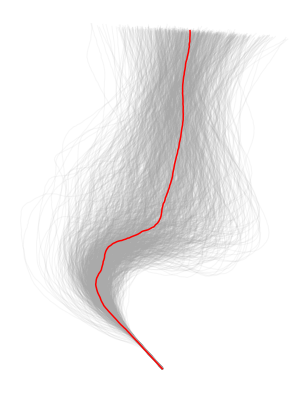

In [10]:
with plt.style.context("traffic"):
    fig, ax=plt.subplots(1, subplot_kw=dict(projection=EuroPP()))
    t_gen.plot(ax, alpha=0.1)
    t_gen.centroid(nb_samples=None, projection=EuroPP()).plot(ax, c="red")

In [11]:
t_gen.to_csv("./outputs/gmm.csv")

### Douglas-Peucker

In [12]:
simplified_t = (
    t_gen
    .simplify(tolerance=1e3)
    .eval(desc="")
)
simplified_t

  0%|          | 0/1000 [00:00<?, ?it/s]

,count
flight_id,
TRAJ_276,13
TRAJ_18,13
TRAJ_359,13
TRAJ_107,13
TRAJ_228,12
TRAJ_365,12
TRAJ_414,12
TRAJ_96,12
TRAJ_687,12


In [13]:
simplified_t.to_csv("./outputs/dp_gmm.csv")

### Navigational Points

In [14]:
navpoints_t = pd.concat([
    flight
    .compute_navpoints()
    .assign(
        flight_id=flight.flight_id,
        callsign=flight.callsign,
        icao24=flight.icao24,
        registration=flight.registration,
        typecode=flight.typecode,
        latitude_0=flight.data.iloc[0].latitude,
        longitude_0=flight.data.iloc[0].longitude,
        altitude_0=flight.data.iloc[0].altitude,
        track_0=flight.data.iloc[0].track,
        groundspeed_0=flight.data.iloc[0].groundspeed,
    )
    .drop(columns=[
        "altitude",
        "description",
        "frequency",
        "magnetic_variation"
    ])
    for flight in tqdm(t_gen)
])
navpoints_t.head()

100%|██████████| 1000/1000 [12:26<00:00,  1.34it/s]


,start,stop,duration,navaid,distance,shift_mean,shift_meanp,name,type,latitude,...,flight_id,callsign,icao24,registration,typecode,latitude_0,longitude_0,altitude_0,track_0,groundspeed_0
0,2021-09-14 08:05:52.478239324+00:00,2021-09-14 08:08:43.139446212+00:00,0 days 00:02:50.661206888,TD003,6.577506,0.079397,0.099397,TD003,FIX,47.785339,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.125977,8.602401,15793.772275,189.401174,257.062559
1,2021-09-14 08:10:28.942130404+00:00,2021-09-14 08:12:39.869400377+00:00,0 days 00:02:10.927269973,ZH305,5.574537,0.094507,0.114507,ZH305,FIX,47.625500,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.125977,8.602401,15793.772275,189.401174,257.062559
2,2021-09-14 08:13:43.172015527+00:00,2021-09-14 08:18:27.305338097+00:00,0 days 00:04:44.133322570,MDR29,7.721759,0.116326,0.136326,MDR29,FIX,47.395000,...,TRAJ_0,TRAJ_0,TRAJ_0,None,None,48.125977,8.602401,15793.772275,189.401174,257.062559
0,2021-09-14 08:05:43.395586962+00:00,2021-09-14 08:10:31.668592671+00:00,0 days 00:04:48.273005709,OSNEM,11.666130,0.149215,0.169215,OSNEM,FIX,47.579694,...,TRAJ_1,TRAJ_1,TRAJ_1,None,None,48.129738,8.520194,13762.973946,195.610805,267.030192
1,2021-09-14 08:10:50.931111047+00:00,2021-09-14 08:11:35.546504760+00:00,0 days 00:00:44.615393713,ZH204,17.614383,0.213051,0.233051,ZH204,FIX,47.449111,...,TRAJ_1,TRAJ_1,TRAJ_1,None,None,48.129738,8.520194,13762.973946,195.610805,267.030192


In [15]:
navpoints_t.to_csv("./outputs/nav_gmm.csv")